# Una aplicación del algoritmo de Grover

Utilizo el algoritmo de Grover para buscar dos elementos en una pequeña base de datos. 

In [1]:
import qiskit
from qiskit import *
from qiskit.visualization import plot_histogram
import math
from math import pi
import matplotlib
%matplotlib inline

Supongamos que nuestros colegas de el Instituto de Investigaciones en Materiales tienen la siguiente base de datos. Esta base de datos presenta distintos materiales numerados del 0-7 (en binario) de los cuales se conocen sus estructuras cristalinas. Estas estructuras resultaron ser solamente una de cuatro: Cúbica simple (SC), cúbica centrada en las caras (FCC), cúbica centrada en el cuerpo (BCC), y hexagonal (HCP). La base de datos es la siguiente:



    
| No. Material | SC | FCC | BCC| HCP |
| --- | --- | --- | --- | --- |
| 000 | 0 | 1 | 0 | 0 |
| 001 | 0 | 0 | 1 | 0 |
| 010 | 0 | 1 | 0 | 0 |
| 011 | 1 | 0 | 0 | 0 |
| 100 | 0 | 0 | 1 | 0 |
| 101 | 1 | 0 | 0 | 0 |
| 110 | 0 | 0 | 0 | 1 |
| 111 | 0 | 0 | 0 | 1 |



Ellos quieren un algoritmo que les ayude a buscar en su base de datos los materiales que cristalizan en alguna estructura en especial. Nos ofrecemos a ayudarles implementando el algoritmo de Grover, pues suponemos que esta situación ocurre en un futuro (esperemos no muy lejano) en el que podemos utilizar computo cuántico en nuestro día a día.


Implementaré una compuerta $U_X$ que marque a los materiales con la estructura $X=CS,FCC,BCC,HCP$ invirtiendo su signo. Para esto utilizaré al menos un qubit auxiliar, pues la implementación de estas compuertas se puede ver como lo siguiente:

  - Asignar una función $f_X$ a cada estructura e implementar la compuerta $U_{f_X}$ para cada estructura disponible . Notemos que $f_X:\{0,1\}^3->\{0,1\}$
  - Cuando la función $f_X(q_2q_1q_0)=1$, invertiré el signo de dicho estado utilizando una compuerta $C-Z$ con el control en el qubit que guarda el valor de la función.
  
Posteriormente utilizaré el algoritmo de Grover, considerando una o dos iteraciones. Lo anterior ya que la teoría [1] indica que cuando una búsqueda tiene $M$ resultados posibles, los estados resultantes de la búsqueda tienen más probabilidad de aparecer al hacer $$O=\sqrt{N/M}$$

En este caso cada búsqueda tiene dos posibles resultados de modo que $\sqrt{8/2}=2$

(Agregar caso M=N/4)

## Preparativos: La compuertas $U_s$ y $C^3-X$
La primera de estas será necesaria para completar una iteración del algoritmo de Grover, después de aplicar el oráculo a los estados correspondientes.
La segunda de ellas será útil para implementar el oráculo que invertirá el signo de los estados buscados en los casos para CS y BCC

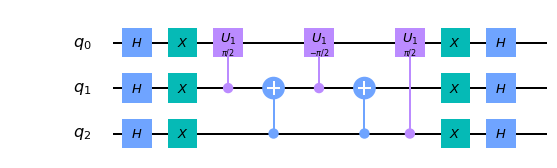

In [2]:
n=3
def us(circuit):
    for i in range(0,n):
        circuit.h(i)
    for i in range(0,n):
        circuit.x(i)
    circuit.cu1(pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(-pi/2,1,0)
    circuit.cx(2,1)
    circuit.cu1(pi/2,2,0)
    for i in range(0,n):
        circuit.x(i)
    for i in range(0,n):
        circuit.h(i)  
        
Us=QuantumCircuit(3)
us(Us)
Us.draw(output="mpl")

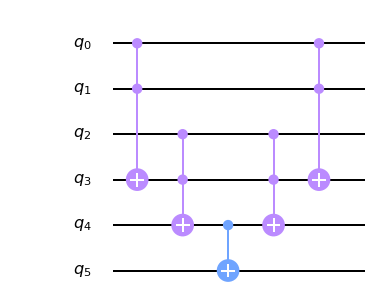

In [3]:
def c3x(circuit):
    circuit.ccx(0,1,3)
    circuit.ccx(2,3,4)
    circuit.cx(4,5)
    circuit.ccx(2,3,4)
    circuit.ccx(0,1,3)
    
CCCX=QuantumCircuit(6)
c3x(CCCX)
CCCX.draw(output="mpl") 

## Buscando materiales CS 
La compuerta implementada $U_{CS}$ invierte el signo de los estados $|011\rangle$ y $|101\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

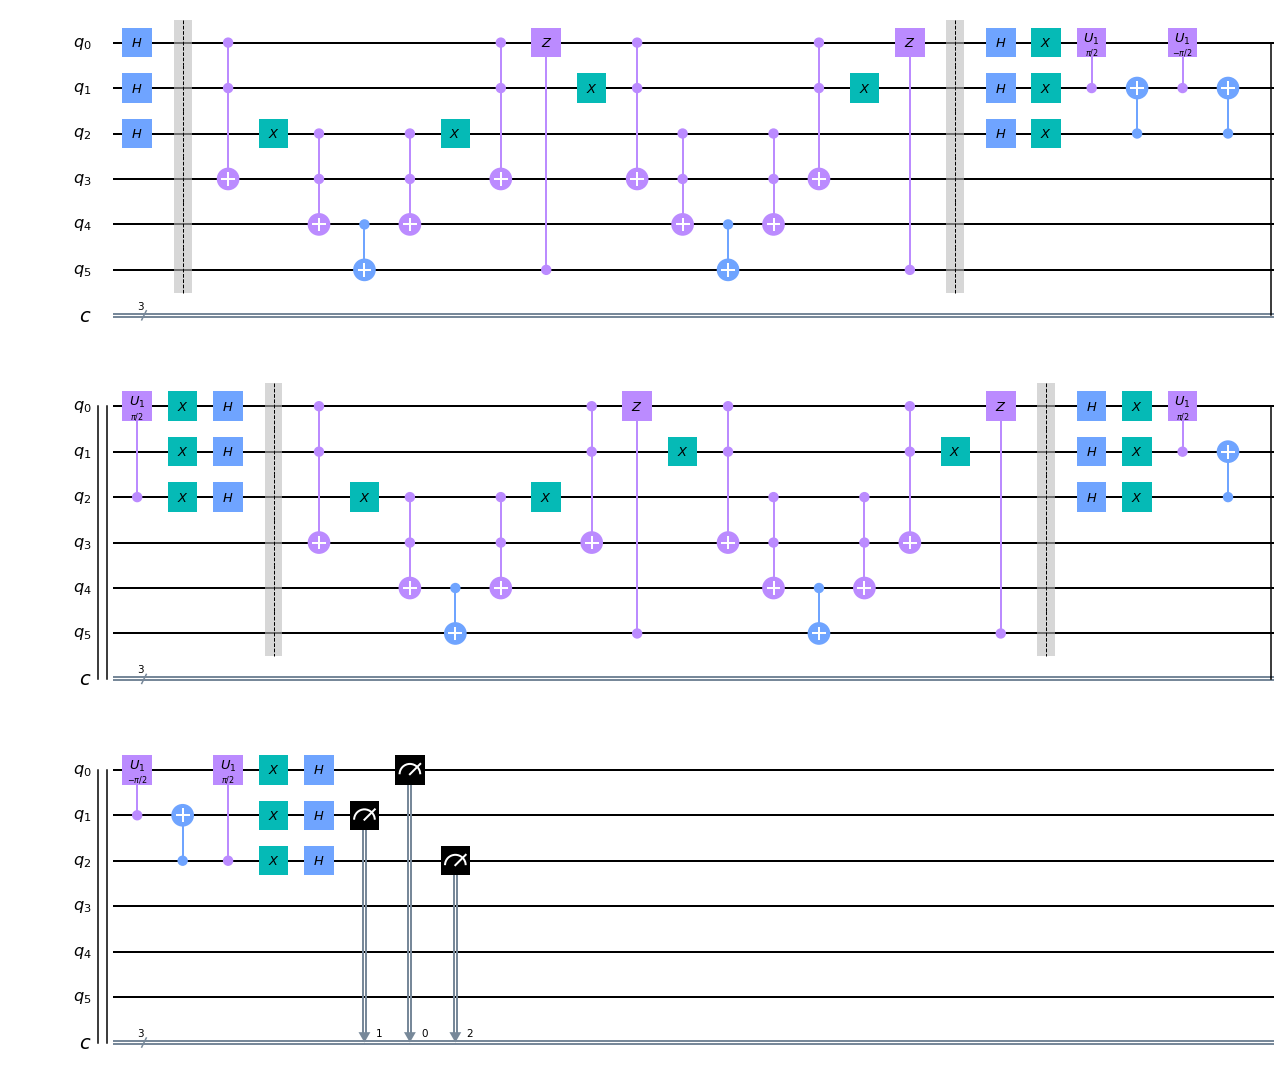

In [36]:
def u_CS(circuit):
    circuit.barrier()
    circuit.ccx(0,1,3)
    circuit.x(2)
    circuit.ccx(2,3,4)
    circuit.cx(4,5)
    circuit.ccx(2,3,4)
    circuit.x(2)
    circuit.ccx(0,1,3)
    circuit.cz(5,0)
    
    circuit.x(1)
    circuit.ccx(0,1,3)
    circuit.ccx(2,3,4)
    circuit.cx(4,5)
    circuit.ccx(2,3,4)
    circuit.ccx(0,1,3)
    circuit.x(1)
    circuit.cz(5,0)
    circuit.barrier()

# La implementación de la compuerta C3-X requiere dos qubits adicionales.
qcCS=QuantumCircuit(6,3)
qcCS.h(range(0,3))
u_CS(qcCS)
us(qcCS)
u_CS(qcCS)
us(qcCS)
qcCS.measure(range(0,3),range(0,3))
qcCS.draw(output='mpl')

# La compuerta U_CS se encuentra entre las barreras.

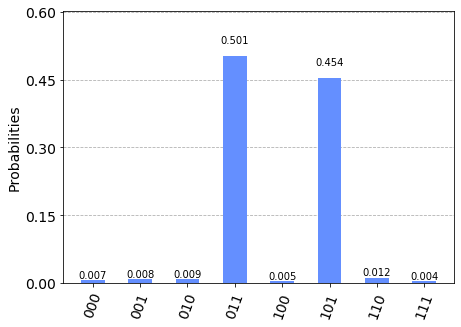

In [37]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(qcCS, qasm, shots=1000)
result = job.result()
countsCS = result.get_counts(qcCS) 
plot_histogram(countsCS)

## Buscando materiales FCC
La compuerta implementada $U_{FCC}$ invierte el signo de los estados $|000\rangle$ y $|010\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

In [6]:
def u_FCC(circuit):
    circuit.barrier()
    circuit.x({0,2})
    circuit.ccx(0,2,3)
    circuit.cz(3,2)
    circuit.x({0,2})
    circuit.barrier()

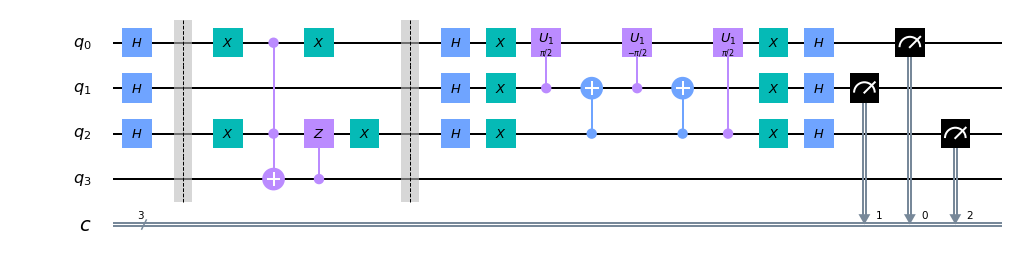

In [38]:
qcFCC=QuantumCircuit(4,3)
qcFCC.h(range(0,3))
u_FCC(qcFCC)
us(qcFCC)
qcFCC.measure(range(0,3),range(0,3))
qcFCC.draw(output='mpl')
#Se comporta raro, no sobrepasar iteraciones


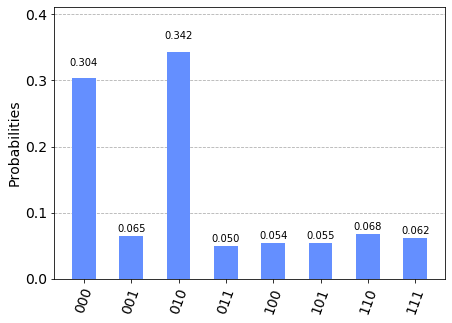

In [39]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(qcFCC, qasm, shots=1000)
result = job.result()
countsFCC = result.get_counts(qcFCC) 
plot_histogram(countsFCC)

## Buscando materiales BCC
La compuerta implementada $U_{BCC}$ invierte el signo de los estados $|001\rangle$ y $|100\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

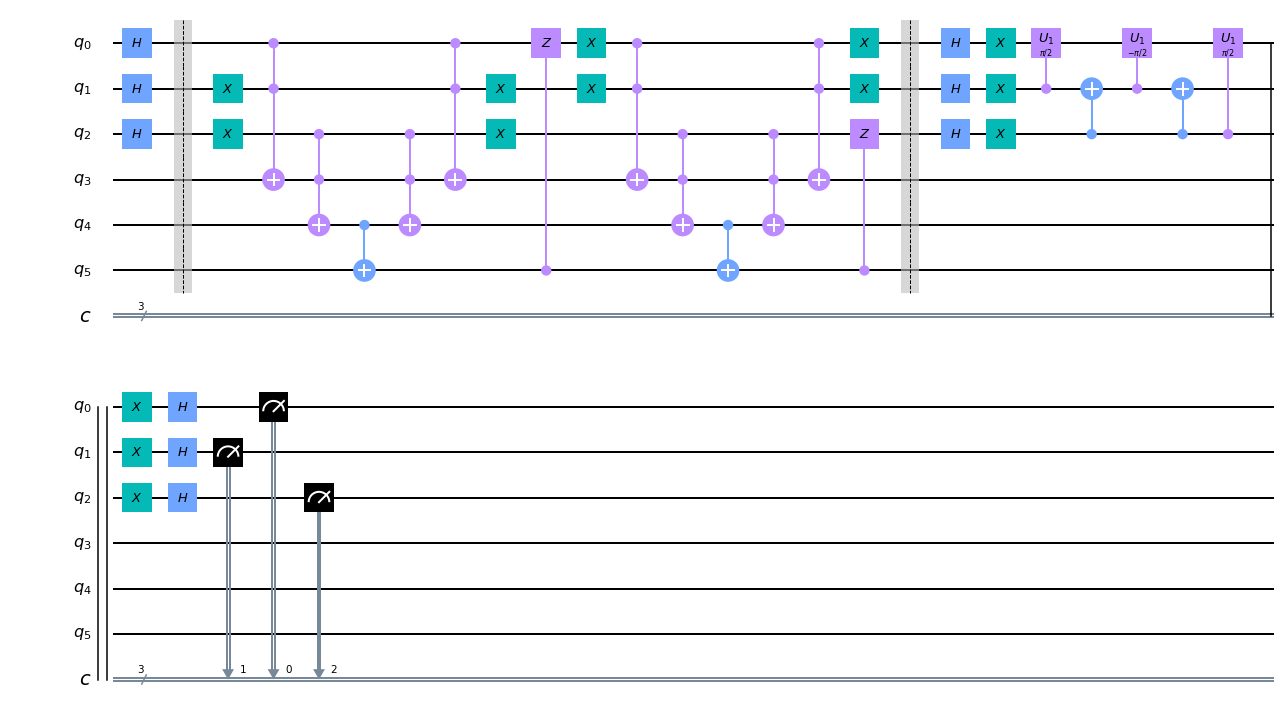

In [42]:
def u_BCC(circuit):
    circuit.barrier()
    circuit.x({1,2})
    c3x(circuit)
    circuit.x({1,2})
    circuit.cz(5,0)
    
    circuit.x({0,1})
    c3x(circuit)
    circuit.x({0,1})
    circuit.cz(5,2)
    circuit.barrier()


qcBCC=QuantumCircuit(6,3)
qcBCC.h(range(0,3))
u_BCC(qcBCC)
us(qcBCC)
qcBCC.measure(range(0,3),range(0,3))
qcBCC.draw(output='mpl')

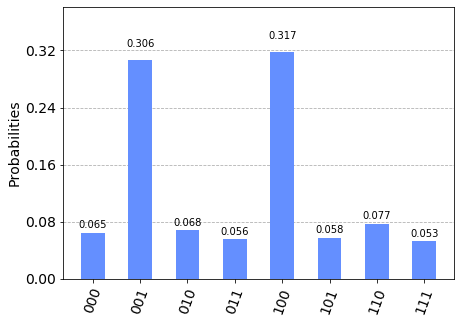

In [43]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(qcBCC, qasm, shots=1000)
result = job.result()
countsBCC = result.get_counts(qcBCC) 
plot_histogram(countsBCC)
# Se comporta chistoso: al hacer una iteración más, el resultado es erróneo


## Buscando materiales HCP
La compuerta implementada $U_{CS}$ invierte el signo de los estados $|110\rangle$ y $|111\rangle$, lo cual permite encontrarlos al aplicar el algoritmo de Grover.

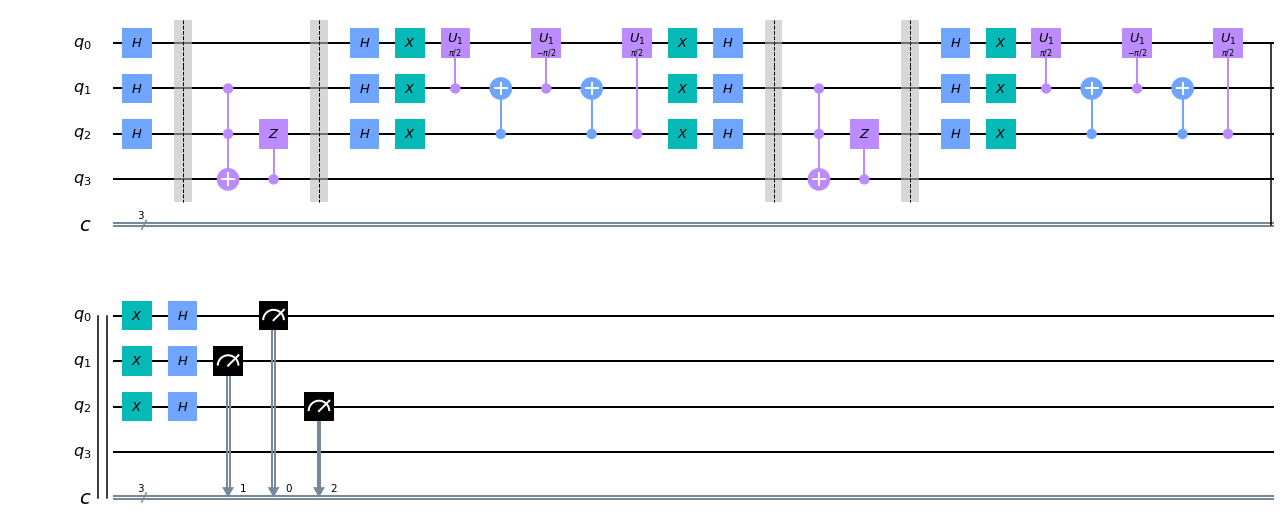

In [44]:
def u_HCP(circuit):
    circuit.barrier()
    circuit.ccx(1,2,3)
    circuit.cz(3,2)
    circuit.barrier()
    
qcH=QuantumCircuit(4,3)
qcH.h(range(0,3))
u_HCP(qcH)
us(qcH)
qcH.measure(range(0,3),range(0,3))
qcH.draw(output='mpl')

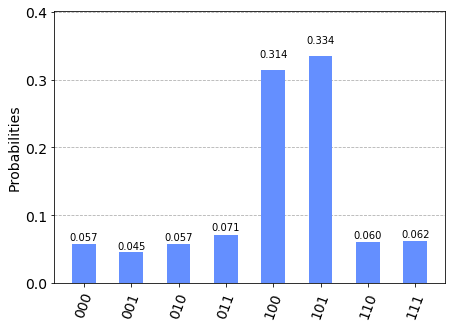

In [45]:
qasm = Aer.get_backend('qasm_simulator')
job = execute(qcH, qasm, shots=1000)
result = job.result()
countsHCP = result.get_counts(qcH) 
plot_histogram(countsHCP)

## Implementación de una función "interpretadora de resultados"
Para cada estructura cristalina, definiremos una función de Python que toma como argumento alguna estructura cristalina, y regresa como resultado los números de los materiales que satisfacen tener dicha estructura. Esta función toma como argumento el tipo de estructura _**entre comillas**_.

In [40]:
def find(struct):
    if struct=="CS":
        #Utilizamos la siguiente forma de ordenar el diccionario countsCS, hacemos lista anidada
        countsCS_L=sorted(countsCS.items(), key=lambda x: x[1])
        #Accedemos a los estados más comúnes en el diccionario, los últimos dos
        print("Los materiales que criztalizan en CS son:", countsCS_L[6][0], ",", countsCS_L[7][0])
    elif struct== "FCC":
        countsFCC_L=sorted(countsFCC.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en FCC son:", countsFCC_L[6][0], ",", countsFCC_L[7][0])
    elif struct== "BCC":
        countsBCC_L=sorted(countsBCC.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en BCC son:", countsBCC_L[6][0],",", countsBCC_L[7][0])
    elif struct=="HCP":
        countsHCP_L=sorted(countsHCP.items(), key=lambda x: x[1])
        print("Los materiales que criztalizan en HCP son:", countsHCP_L[6][0],",",countsHCP_L[7][0])

Ahora solo resta llamar la función <code>find()<code>

In [41]:
#Cambie el tipo de estructura entre comillas para verificar con la Tabla 1
find("CS")

Los materiales que criztalizan en CS son: 101 , 011


## Algunos aspectos interesantes y limitaciones.
Nuestros colegas del IIM ya tienen un algoritmo de búsqueda funcional, sin embargo los resultados obtenidos motivan algunas preguntas acerca de las probabilidades obtenidas y el funcionamiento del algoritmo

Los histogramas anteriormente presentados motivan las siguientes preguntas:
- ¿Porqué ahora las probabilidades de los dos más probables suman sólamente alrededor del 60% para los casos FCC, BCC, HCP? [3]
- ¿Porqué se sobrepasa el límite de iteraciones el algoritmo falla?

Esto se arregló en la segunda versión.

### Bibliografía:
- [1] Grover, L. K. (1996, Julio). _A fast quantum mechanical algorithm for database search._ In Proceedings of the twenty-eighth annual ACM symposium on Theory of computing (pp. 212-219).
- [2] Nielsen, M. A., & Chuang, I. (2002). _Quantum computation and quantum information._
- [3] Boyer, M., Brassard, G., Høyer, P., & Tapp, A. (1998). _Tight bounds on quantum searching._ Fortschritte der Physik: Progress of Physics, 46(4‐5), 493-505.
    